In [29]:
# !pip install pandas
# !pip install watermark
# !pip install seaborn
# !pip install biopython
# !pip install sklearn
import os
import re 
# from Bio import SeqIO
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np 
import watermark
import random 
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [30]:
%load_ext watermark
%watermark
%watermark --iversion

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2021-05-02T11:06:22.722067+08:00

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 11, GenuineIntel
CPU cores   : 8
Architecture: 64bit

pandas    : 1.2.4
numpy     : 1.20.1
re        : 2.2.1
matplotlib: 3.3.4
seaborn   : 0.11.1
watermark : 2.2.0



## TODO
- 把WAM模型包装为类？
- 原来不对序列编码，发现运行速度贼慢，希望用numpy速度会快点  

## Data Cleaning
- train set contains 462 files,2831 introns, all suffies of file is "TXT",the letters are  lowercase  letters. The first line is "LOCUS AB000381 35863 bp DNA PRI 14-MAY-1997", gapped by lots of whitespace
- test set contains 570 files,2071 introns,the suffixes of file contains "TXT"and "txt",and the letters are capital letters.The fist line in each file starts with like ">>ACU08131"
- 现在有一个问题，为什么提取的位点最后一个位点都是t开头的，而且几乎就没有gt donor site
解决了，因为最后一个外显子没有donor site

## 文件预处理
创建文件夹（python中如果一个文件夹不存在，没法通过创建文件时同时创建文件）
- 创建output文件夹用于保存得到的训练集和测试集的数据和分析结果
- 创建predict文件夹用于保存预测的结果

In [31]:
def mkdir(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)
    else:
        pass
mkdir("output")
mkdir("predict")

一些全局变量设定

In [32]:
left=20
right=40
signal_num = left+right
bases="ACGT"
lower_bases="acgt"

读取Training Set 和Testing Set文件夹，得到该文件夹下所有文件路径

In [33]:

def loadFile(file_dir):
    '''
    Function: Read  All files in the Training Set Folder and Testing Set Folder
    Parameter：file_dir
    Output: file_path,locus_list
    Attention: do not load non-fasta files!
    '''
    file_path = []
    file_locus_list = []
    count=0
    all_file = tqdm(os.listdir(file_dir), desc=f'LOADING {file_dir}')
    for file_name in all_file:
        count+=1
        suffix = re.findall("\.(.+$)",file_name)[-1].lower()
        # or  suffix = file_name.split(".")[1].lower()
        if suffix != "txt":
            continue
        path = f"{file_dir}/{file_name}"
        file_path.append(path)
    all_file.write(f"{count} Files Loading Finished!")
    all_file.close()
    print()
    return file_path

train_file_path =loadFile('Training Set')
test_file_path =loadFile('Testing Set')
# print(train_file_path)

LOADING Training Set:   0%|          | 0/463 [00:00<?, ?it/s]

463 Files Loading Finished!



LOADING Testing Set:   0%|          | 0/571 [00:00<?, ?it/s]

571 Files Loading Finished!



读取文件
> 小插曲：尝试使用bipython的模块来加载，然而好像不太好用……还是用自己的函数吧
>```python
># for seq_record in SeqIO.parse('Testing Set/ACU08131.TXT', "fasta"):
>#     print(seq_record.id)
># #     print(type(seq_record.id))
># #     print(seq_record.seq)
>#     print(str(seq_record.seq))
>```

 读取每个文件，抽取每个文件的包含的信息，比如外显子数目和位置、donor site和acceptor site位置、抽取donor site 前left和后right的signal序列，对acceptor 抽取的是前right后left的signal 序列

In [34]:
def extract_donor_signal(file_path,folder):
    '''
    Parameter：train_file_path|test_file_path [set_folder]
    Output:file_donor_positions,file_acceptor_positions,file_donor_signals,donor_signal_all
    '''
    print(f'Extract {folder} Set donor signals'.center(50, '*'))
    donor_positions= [] #1
    acceptor_positions= [] #1
    donor_signals=[]  #1
    acceptor_signals=[]   #1
    all_donor_signal=[]  
    all_acceptor_signal=[]
    length_list = [] #1
    seq_list = [] #1
    exons = [] #1
    locus =[]
    files = tqdm(file_path, desc=f'{folder} Progressing：')
    for file in files:
        f = open(file)
        #  first line: extract gene locus
        first_line =f.readline() 
        if folder == "Test":
            locus.append(re.search(">(.+)$",first_line).group(1))
        elif folder=="Train":
            locus.append(first_line.split()[1]) 
        #  second line: extract  donor and acceptor site positions
        second_line=f.readline()  
        exon_positions_list = re.findall(r'(\d+)\.\.(\d+)',second_line)
        donor_positions_list = [int(pos_set[1])+1 for pos_set in exon_positions_list[:-1]]
        acceptor_positions_list= [int(pos_set[0])-1 for pos_set in exon_positions_list[1:]]
        exons.append(exon_positions_list)
        donor_positions.append(donor_positions_list)
        acceptor_positions.append(acceptor_positions_list)
        seq = ''
        # extract  seq info
        for line in f.readlines():
                seq += line.strip()
        seq_length = len(seq)
        seq_list.append(seq.lower())
        length_list.append(seq_length)
        # extract  donor site signal
        donor_signal=[]
        for pos in donor_positions_list:
            signal_range = seq[pos-1-left:pos-1+right].lower()
            donor_signal.append(signal_range)
            all_donor_signal.append(signal_range)
        donor_signals.append(donor_signal)
        # extract  acceptor site signal
        acceptor_signal=[]
        for pos in acceptor_positions_list:
            signal_range = seq[pos-right:pos+left].lower()
            acceptor_signal.append(signal_range)
            all_acceptor_signal.append(signal_range)
        acceptor_signals.append(acceptor_signal)
    df_set_info = pd.DataFrame({'Path':file_path, 'Locus':locus,"Length":length_list,"Exon Num":[ len(exons) for exons  in exons],\
 "Exon Location":exons,"Donor Site":donor_positions,"Acceptor Site":acceptor_positions,"Donor signals":donor_signals,"Acceptor signals":acceptor_signals})
    df_set_info_seq = df_set_info.copy()
    df_set_info_seq["Seq"] = seq_list
    df_set_info_seq.to_csv(f'output/{folder}_set_info.csv',index=None)
    df_set_info.to_csv(f'output/{folder}_set_info(non-seq).csv',index=None)
    print(f"Extract Folder {folder} info Finished!")
    return all_donor_signal,all_acceptor_signal,seq_list,donor_positions,acceptor_positions

train_donor_signal_all_str,train_acceptor_signal_all_str,train_seq_list,\
train_donor_positions,train_acceptor_positions=extract_donor_signal(train_file_path,folder="Train")
test_donor_signal_all_str,test_acceptor_signal_all_str,test_seq_list,\
test_donor_positions,test_acceptor_positions=extract_donor_signal(test_file_path,folder="Test")

*********Extract Train Set donor signals**********


Train Progressing：:   0%|          | 0/462 [00:00<?, ?it/s]

Extract Folder Train info Finished!
**********Extract Test Set donor signals**********


Test Progressing：:   0%|          | 0/570 [00:00<?, ?it/s]

Extract Folder Test info Finished!


In [35]:
train_donor_signal_all_str[0:3]
train_acceptor_signal_all_str[0:3]

['tgccaccatgcgcgctcagtgtaagtatcattccctctcactgtcctggagaggacgaga',
 'ctgtatgacaatctccattcgtaagtacctcttggtcatttggacacattgtagattagt',
 'atcgtggtctatgtggtagggtaagagagaagagcttttggccaggctggaggggcaagg']

['agtggagcagaagcctgaagcctgctttctcccctctcagggacttacagtttgagatgc',
 'atgtgaaatcaattattttcattgctgcttctttttttaggcataaattctcgtgaacta',
 'cgctggggacacaccacactgcccgacttctcctccccaggtgggcgctcctcgccaaaa']

把提取的donor_signal和acceptor_signal保存

In [36]:
def signal_to_csv(signal_str,mode,folder="Train"):
    """
    output: csv
    """
    signal_list=[list(line) for line in signal_str]
    if mode=="donor" or mode=="nonDonor":
        col_name = list(range(-left,right))
    elif mode=="acceptor":
        col_name = list(range(-right+1,left+1))
    donorDf = pd.DataFrame(columns=col_name, data=signal_list, index=None)
    print(donorDf)  # [2843 rows x 9 columns]
    donorDf.to_csv(f'output/{folder}_{mode}_signal_info.csv',index=None)
    

def save_donors_str(signal_str,filename="signal_str"):
    """
    output: txt
    """
    f = open(f'output/{filename}.txt', 'w')
    for donor in signal_str:
        donor = donor.lower()  # 存入文件时，把所有字符都规范成小写
        f.write(donor + '\n')
    f.close()
    print(f'save {filename} successful!')

signal_to_csv(train_donor_signal_all_str,folder="Train",mode="donor")
signal_to_csv(train_acceptor_signal_all_str,folder="Train",mode="acceptor")
signal_to_csv(test_donor_signal_all_str,folder="Test",mode="donor")
signal_to_csv(test_acceptor_signal_all_str,folder="Test",mode="acceptor")
save_donors_str(train_donor_signal_all_str,filename="Train_donor_signal_str")
save_donors_str(train_acceptor_signal_all_str,filename="Train_acceptor_signal_str")
save_donors_str(test_donor_signal_all_str,filename="Test_donor_signal_str")
save_donors_str(test_acceptor_signal_all_str,filename="Test_acceptor_signal_str")

     -20 -19 -18 -17 -16 -15 -14 -13 -12 -11  ...  30  31  32  33  34  35  36  \
0      t   g   c   c   a   c   c   a   t   g  ...   g   a   g   g   a   c   g   
1      c   t   g   t   a   t   g   a   c   a  ...   g   t   a   g   a   t   t   
2      a   t   c   g   t   g   g   t   c   t  ...   a   g   g   g   g   c   a   
3      a   c   t   t   c   g   t   g   a   a  ...   c   a   a   g   t   c   c   
4      t   t   c   a   g   g   g   c   a   g  ...   c   c   c   t   t   g   t   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
2376   c   c   c   a   c   a   a   g   g   g  ...   g   g   g   c   t   t   c   
2377   a   g   g   a   a   a   a   t   a   a  ...   c   a   a   t   g   a   a   
2378   a   g   g   a   a   g   g   a   g   a  ...   c   a   t   c   c   t   a   
2379   g   c   g   t   c   g   g   a   g   t  ...   g   g   t   a   c   c   t   
2380   t   c   t   c   g   a   a   g   c   c  ...   g   a   g   g   g   a   a   

      37  38  39  
0      a

这里有一个比较坑的一点是，序列里才不只是有ACGT，还有其他未知碱基，但统计完之后发现其实提取的signal序列都没用未知碱基，所以之后处理可以考虑提取的序列如果包含未知碱基

In [37]:
from  collections import Counter
# def count_each_char(str_list):
#     str_list = tqdm(str_list, desc='Counting  Base Distribution:')
#     dict1 =  Counter({})
#     for seq in str_list:
#         dict2 = Counter((str_list))
#         dict1 +=dict2
#     return dict(dict1)
def count_each_char(str_list):
    dict = {}
    str_list = tqdm(str_list, desc='Counting  Base Distribution:')
    for seq in str_list:
         for i  in seq:
            if i not in dict:
                dict[i] = 1
            else:
                dict[i] += 1
    return dict
base_dis_1 = count_each_char(train_seq_list)
base_dis_2 = count_each_char(train_donor_signal_all_str)
base_dis_3 = count_each_char(test_seq_list)
base_dis_4 = count_each_char(test_donor_signal_all_str)
print("Distribution of all bases in training set\n",base_dis_1)
print("Distribution of donor site bases in training  set\n",base_dis_2)
print("Distribution of all bases in testing set\n",base_dis_3)
print("Distribution of donor site  bases in testing set\n",base_dis_4)

Counting  Base Distribution::   0%|          | 0/462 [00:00<?, ?it/s]

Counting  Base Distribution::   0%|          | 0/2381 [00:00<?, ?it/s]

Counting  Base Distribution::   0%|          | 0/570 [00:00<?, ?it/s]

Counting  Base Distribution::   0%|          | 0/2079 [00:00<?, ?it/s]

Distribution of all bases in training set
 {'g': 1306260, 'c': 1282733, 'a': 1436966, 't': 1498203, 'n': 682, 'k': 28, 's': 27, 'r': 15, 'y': 26, 'w': 14, 'm': 16, 'v': 2, 'b': 4}
Distribution of donor site bases in training  set
 {'t': 31912, 'g': 44201, 'c': 34682, 'a': 32058, 'r': 2, 'w': 1, 'n': 4}
Distribution of all bases in testing set
 {'c': 689433, 't': 762900, 'g': 702343, 'a': 736600, 'n': 862, 'b': 1, 'r': 5, 'y': 3, 'k': 1, 's': 1}
Distribution of donor site  bases in testing set
 {'c': 28898, 'a': 29074, 'g': 36963, 't': 29784, 'n': 21}


序列编码函数，之后应该有大用！

In [38]:
sub_pattern = re.compile('[^acgt]')
pattern = re.compile("[^acgt]")
def string_to_array(my_string):
    """
    function to convert a DNA sequence string to a numpy array
    converts to lower case, changes any non 'acgt' characters to 'n'
    like: ['c' 'a' 't' 'g' 'g']
    """
#     my_string = my_string.lower()
    my_string = sub_pattern.sub('z', my_string)
    my_array = list(my_string)
#     my_array = np.array(list(my_string))
    return my_array
def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

def ordinal_encoder(my_array):
    """
    function to encode a DNA sequence string as an ordinal vector
    returns a numpy vector with a=0, c=1, g=2, t=3, n=4
    like: [1 0 3 2 2 1]
    """
    label_encoder = LabelEncoder()
    label_encoder.fit(np.array(['a','c','g','t','z']))
    integer_encoded = label_encoder.transform(my_array)
    return integer_encoded
def one_hot_encoder(my_array):
    label_encoder = LabelEncoder()
    label_encoder.fit(np.array(['a','c','g','t','z']))
    integer_encoded = label_encoder.transform(my_array)
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot_encoded = np.delete(onehot_encoded, -1, 1)
    return onehot_encoded
def clean_noknown(donor_signal):
    no_known =pattern.search(nonDonor)
    return not no_known
            



from multiprocessing import Pool


char_to_int = {c:i for i, c in enumerate(lower_bases)}
def process_signal(donor):
    donor = list(donor)
    integer_encoded = [char_to_int[char] for char in donor]
    return list(integer_encoded)

def code_all_signal(signal_all_str):
    signal_all_str = tqdm(signal_all_str, desc='code_all_signal:')
    signal_array=map(string_to_array,signal_all_str)
    code = list(map(ordinal_encoder,signal_array))
#     code=np.array(list(signal_array),dtype=np.int32)
    return np.array(code)

# getKmers(sequence, size)
# ordinal_encoder(string_to_array(test_sequence))
# one_hot_encoder(string_to_array(test_sequence))

# mySeq = 'CATGGCCATNNNNNNNNGAGCGGGGGGGGG'
# mySeq2 = 'GATGGCCATCCCCGCCCGAGCGGGGGGGG'
# mySeq3 = 'CATGGCCATCCCCGCCCGAGCGGGCGGGG'
# integer_encoded = ordinal_encoder(string_to_array(mySeq))
# one_hot_matrix = one_hot_encoder(string_to_array(mySeq))
# print(string_to_array(mySeq))
# print(string_to_array(mySeq).reshape([6,-1]))
# print(integer_encoded)
# print(one_hot_matrix[0:5])
code_all_signal(train_donor_signal_all_str[1:20])

code_all_signal::   0%|          | 0/19 [00:00<?, ?it/s]

array([[1, 3, 2, ..., 0, 2, 3],
       [0, 3, 1, ..., 0, 2, 2],
       [0, 1, 3, ..., 3, 3, 3],
       ...,
       [0, 3, 3, ..., 1, 0, 1],
       [2, 3, 2, ..., 2, 0, 3],
       [1, 2, 0, ..., 2, 0, 0]])

In [39]:
#numpy 统计数组的值出现次数与np.bincount()详细解释
import numpy as np
from collections import Counter
# train_donor_signal_int
# data = train_donor_signal_int[0]
data = [1,1,1,1,1,1,1,1,1]
# print()
# 方法一
print('Counter(data)\n',Counter(data)) # 调用Counter函数
print('==========')
 
# 方法二
print('np.unique(data)\n',np.unique(data,return_counts=True)[1][0:4]) # unique返回的是已排序数组
print('np.unique(data)\n',np.unique(data))
for i in np.unique(data):
	print(np.sum(data==i))
## np.unique(data,return_counts=True) 能直接返回unique的结果，也能返回统计结果
## 效果：(array([1.1, 2. , 3. , 4. , 5. ]), array([3, 1, 1, 3, 2], dtype=int64))

Counter(data)
 Counter({1: 9})
np.unique(data)
 [9]
np.unique(data)
 [1]
9


code_all_signal::   0%|          | 0/2381 [00:00<?, ?it/s]

Calculating Prior Probability::   0%|          | 0/60 [00:00<?, ?it/s]

         p(A)      p(C)      p(G)      p(T)
-20  0.255355  0.273415  0.252415  0.218816
-19  0.225535  0.269215  0.283914  0.221336
-18  0.233935  0.262495  0.304074  0.199496
-17  0.266275  0.248635  0.278874  0.206216
-16  0.231415  0.301554  0.274255  0.192776
-15  0.248635  0.290634  0.254515  0.206216
-14  0.245275  0.301134  0.235615  0.217976
-13  0.219656  0.299034  0.261235  0.220076
-12  0.248215  0.287274  0.258715  0.205796
-11  0.246535  0.312894  0.224696  0.215876
-10  0.234775  0.262915  0.266695  0.235615
-9   0.263755  0.257875  0.291054  0.187316
-8   0.220076  0.283074  0.264595  0.232255
-7   0.237715  0.275934  0.274255  0.211676
-6   0.262915  0.257035  0.263335  0.216716
-5   0.262075  0.277614  0.231835  0.228475
-4   0.270055  0.305334  0.241075  0.183536
-3   0.328433  0.363713  0.188576  0.119278
-2   0.585468  0.137757  0.133557  0.143217
-1   0.094078  0.034019  0.788744  0.083158
 0   0.000000  0.000000  1.000000  0.000000
 1   0.000000  0.000000  0.00000

code_all_signal::   0%|          | 0/2381 [00:00<?, ?it/s]

Calculating Prior Probability::   0%|          | 0/60 [00:00<?, ?it/s]

         p(A)      p(C)      p(G)      p(T)
-39  0.203696  0.261235  0.273415  0.261235
-38  0.209996  0.271735  0.261655  0.256615
-37  0.207476  0.276354  0.255355  0.260815
-36  0.199496  0.272155  0.262075  0.266275
-35  0.217136  0.262915  0.257455  0.262495
-34  0.232255  0.290214  0.231835  0.245275
-33  0.202856  0.283914  0.238555  0.274675
-32  0.196136  0.288954  0.234775  0.280134
-31  0.190256  0.296514  0.228475  0.284754
-30  0.224696  0.293154  0.212516  0.269215
-29  0.221756  0.292314  0.219236  0.266695
-28  0.216716  0.312894  0.195716  0.274675
-27  0.223856  0.309534  0.179756  0.286854
-26  0.217976  0.306174  0.179336  0.296514
-25  0.217556  0.311634  0.194876  0.275934
-24  0.222596  0.303234  0.155397  0.318774
-23  0.196136  0.314994  0.169677  0.319194
-22  0.219656  0.297354  0.169677  0.313314
-21  0.205376  0.319614  0.165057  0.309954
-20  0.191516  0.332633  0.157497  0.318354
-19  0.179756  0.322134  0.155397  0.342713
-18  0.158757  0.329693  0.16211

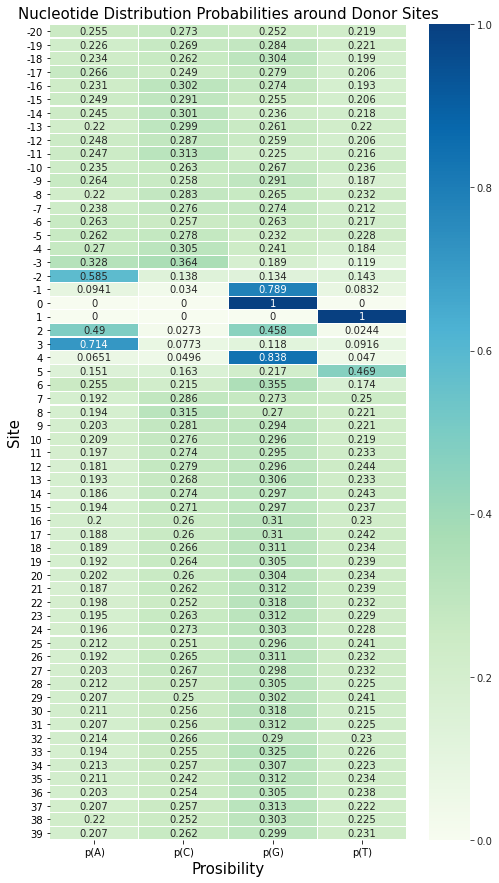

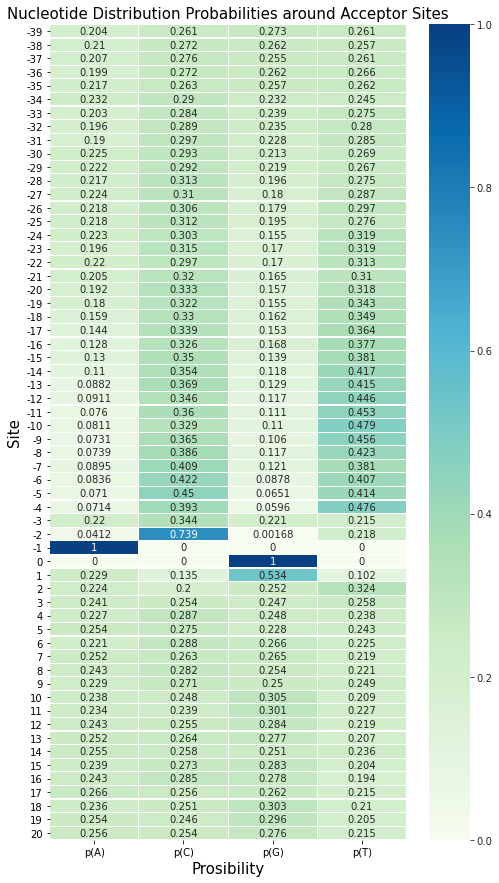

In [40]:

def cal_priorProbability(donor_signal) :
    """
    为了优化计算先验概率的性能，导致现在不能输入非atcg的了……
    """
    count= np.zeros((signal_num,4),dtype=np.int32)
    cols = tqdm(range(signal_num), desc='Calculating Prior Probability:')
    for col in cols:
        count[col]=np.bincount(donor_signal[:,col],minlength=4)[0:4]
#         count[col]=np.unique(donor_signal[:,col],return_counts=True)[1][0:4]
#     print(count)
    priors = count/len(donor_signal)
    cols.close()
    return priors

def prior_to_csv(priors,signal,mode):
    pri_col_name = [f'p({base})' for base in bases ]
    if signal=="donor" or signal=="nonDonor":
        pri_row_name= list(range(-left,right))
    elif signal=="acceptor":
        pri_row_name = list(range(-right+1,left+1))
    priorDf= pd.DataFrame(index=pri_row_name,columns=pri_col_name, data=priors)
    print(priorDf)  
    if signal=="nonDonor":
        priorDf.to_csv(f'output/prior_probability_(P{mode}).csv')
    else:
        priorDf.to_csv(f'output/{signal}_prior_probability_(P{mode}).csv')
    return priorDf

def ShowHeatMap(DataFrame,title="HeatMap",size=(8, 15),color='GnBu'):
    """
    #     ylabels = DataFrame.columns.values.tolist() #保存df的列名为label
    #数据的index和columns分别为heatmap的y轴方向和x轴方向标签
    # cmap=sns.light_palette("#2ecc71", as_cmap=True)
    xticklabels=['三连啊','关注公众号啊','pythonic生物人','收藏啊','点赞啊','老铁三连三连'] , #x轴方向刻度标签开关、赋值，可选“auto”, bool, list-like（传入列表）, or int,
            yticklabels=True, #y轴方向刻度标签开关、同x轴
    colormap = plt.cm.RdBu,"YlGnBu" # 颜色映射
    """
    

    f, ax = plt.subplots(figsize=size)
    ax.set_title(title,fontsize=15)
    with sns.axes_style("white"):
        sns.heatmap(DataFrame,
                    cmap=color,  
                    annot=True, # show num
                    fmt='.3g',# num format
#                     mask=DataFrame > 0.25,
#                     annot_kws={"weight": "bold"}
                    linewidths=.2,
                    yticklabels=True,
                    xticklabels=True,
                   )
    
    ax.set_ylabel("Site",fontsize=15)
    ax.set_xlabel("Prosibility",fontsize=15)
    plt.savefig(f"output/{title}-left{left}-right{right}.png",dpi=400)

# train_donor_signal_all_str = filter(clean_noknown, train_donor_signal_all_str) 本来还想过滤一下非donor的看来没必要
train_donor_signal_int=code_all_signal(train_donor_signal_all_str)
donor_priors_p=cal_priorProbability(train_donor_signal_int)
df_donor_priors_p=prior_to_csv(donor_priors_p,signal="donor",mode="+")
train_acceptor_signal_int=code_all_signal(train_acceptor_signal_all_str)
acceptor_priors_p=cal_priorProbability(train_acceptor_signal_int)
df_acceptor_priors_p=prior_to_csv(acceptor_priors_p,signal="acceptor",mode="+")
ShowHeatMap(df_donor_priors_p,title="Nucleotide Distribution Probabilities around Donor Sites")
ShowHeatMap(df_acceptor_priors_p,title="Nucleotide Distribution Probabilities around Acceptor Sites")

<AxesSubplot:>

Text(0.5, 0, 'Site')

Text(0, 0.5, 'Percentage')

Text(0.5, 1.0, 'Nucleotide Distribution Probabilities around Acceptor Sites')

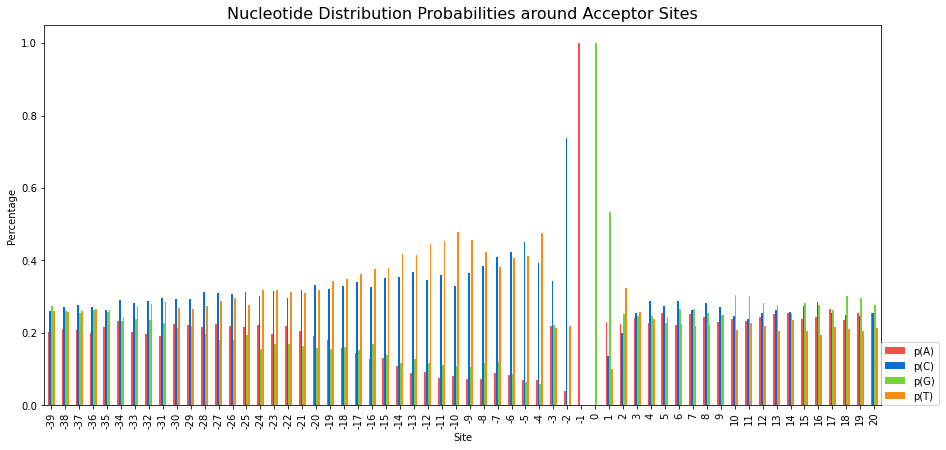

In [41]:

df_acceptor_priors_p.plot.bar(color=["#ff4d4f","#096dd9","#73d13d","#fa8c16"],figsize=(15,7))
# plt.figure(figsize=(20, 6.5))
# plt.xticks(rotation=90)
plt.xlabel("Site")
plt.ylabel("Percentage")
plt.title("Nucleotide Distribution Probabilities around Acceptor Sites",fontsize=16)
plt.legend(loc=[1,0],ncol=1)
plt.savefig("output/acceptor signal unstacked.png",bbox_inches = 'tight')

<AxesSubplot:>

Text(0.5, 0, 'Site')

Text(0, 0.5, 'Percentage')

Text(0.5, 1.0, 'Nucleotide Distribution Probabilities around Donor Sites')

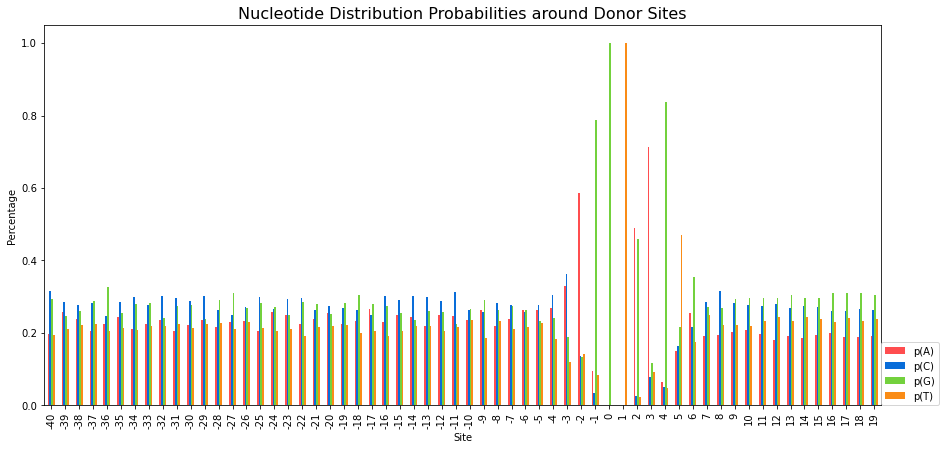

In [27]:

df_donor_priors_p.plot.bar(color=["#ff4d4f","#096dd9","#73d13d","#fa8c16"],figsize=(15,7))
# plt.figure(figsize=(20, 6.5))
# plt.xticks(rotation=90)
plt.xlabel("Site")
plt.ylabel("Percentage")
plt.title("Nucleotide Distribution Probabilities around Donor Sites",fontsize=16)
plt.legend(loc=[1,0],ncol=1)
plt.savefig("output/donor signal unstacked.png",bbox_inches = 'tight')

In [13]:
train_donor_signal_int
len(train_donor_signal_int)

array([[1, 3, 1, ..., 3, 1, 0],
       [3, 2, 3, ..., 0, 3, 3],
       [0, 2, 0, ..., 3, 3, 2],
       ...,
       [0, 0, 1, ..., 0, 0, 3],
       [0, 1, 0, ..., 1, 3, 3],
       [1, 1, 1, ..., 3, 2, 3]])

2381

In [24]:
import itertools

def joint_count(donor,count):
    for j in range(8):
        code1,code2 = donor[j:j+2]
        pos = 4*code1+code2
        count[j][pos] +=1
    return count
     

#计算条件概率

def cal_conditionalProbability(donor_signal,priors):
    N,M=signal_num-1,16
    count= np.zeros((N,M),dtype=np.int32)
    conditional = np.zeros((N,M),dtype=np.float32)
    print(count.shape)
    # count
    donor_signal = tqdm(donor_signal, desc='Calculating Conditional Probability:')
    for donor in donor_signal:
        for j in range(N):
            if 4 not in donor[j:j+1]:
                count[j][4*donor[j]+donor[j+1]] +=1
            else:
                pass #跳过
    #  joint
    joint= count/(len(donor_signal))
    ## conditional P(i+1,A|i,C) = P(A,C)/P(C) 第i位是C，第i+1位为A的概率，
    for k in itertools.product(range(N),range(4),range(4)):
        i = k[0]
        j = k[1]
        m = k[2]
        if priors[i][j]:
            conditional[i][4*j+m] = joint[i][4*j+m]/priors[i][j]
        else:
            pass
    return conditional
def conditional_to_csv(conditional,signal,mode):
    conditional_col_name = [f'p({i},{j})' for i in bases for j in bases ]
    conditional_row_name=list(range(-left+1,right))
    conditionalDf= pd.DataFrame(index=conditional_row_name,columns=conditional_col_name, data=conditional)
    print(conditionalDf) 
    if signal=="nonDonor":
        conditionalDf.to_csv(f'output/conditionalDf_probability(P{mode}).csv')
    else:
        conditionalDf.to_csv(f'output/{signal}_conditionalDf_probability(P{mode}).csv')
    return conditionalDf
    
donor_conditional_p = cal_conditionalProbability(train_donor_signal_int,donor_priors_p)
df_donor_conditional_p =conditional_to_csv(donor_conditional_p,signal="donor",mode="+")
ShowHeatMap(df_donor_conditional_p,size=(14,10),title="Dependence between Adjacent Base Pairs of Donor Sites")
# acceptor_conditional_p=cal_conditionalProbability(train_acceptor_signal_int,acceptor_priors_p)
# conditional_to_csv(acceptor_conditional_p,signal="acceptor",mode="+")


(39, 16)


Calculating Conditional Probability::   0%|          | 0/2381 [00:00<?, ?it/s]

IndexError: index 16 is out of bounds for axis 0 with size 16

In [ ]:
# create 
def create_nonDonor(seqs_DNA, donor_locations, acceptor_locations):
    '''
    # 目前是暴力把所有非signal位点都导出，5510888 
    改了下编码格式 怎么变成4922041……不过和老师给的概率就很接近了……
    求先验概率倒是变快了很多
    为什么这个函数我越优化越慢呢……事实证明， 应该一次性编码，而不是一个序列一次编码
    '''
    

    nonDonors = []
    file_num = tqdm(range(len(donor_locations)), desc='Creating Non Donor Signal Sequence:')
    for i in file_num:
        # 每个文件循环
        file_seq_DNA = seqs_DNA[i]
        num = len(donor_locations[i])  
        length = len(file_seq_DNA)
        donor_signals_start=[pos-1-left for pos in donor_locations[i]]
        acceptor_signals_start=[pos-right for pos in acceptor_locations[i] ]
        signals_start=sorted(donor_signals_start+acceptor_signals_start)
        for index in range(length-signal_num+1):
            if index not in signals_start:
                nonDonor = file_seq_DNA[index:index + signal_num]
                no_known =pattern.search(nonDonor)
                if no_known:
                    break
                else:
                    yield nonDonor
        # 把所有假位点生成之后，还继续生成？
#         slice = random.sample(phonyDonor_temp, length)
#         nonDonors.extend(slice)
    print('Created Non Donor Signal Sequence successful!')
#     return nonDonor_temp


nonDonor_list=create_nonDonor(train_seq_list, train_donor_positions, train_acceptor_positions)
nonDonor_list=list(nonDonor_list)
print(len(nonDonor_list))

可以看到导出了4592个非donor site siganl 序列（因为剔除了很多未知碱基吧?按道理来说这种方式不应该出现超万个的序列吗？？？？)  
好吧，我知道了，原来又是循环位置放错  
现在导出了5511802个  
现在导出了4922041个

In [ ]:
count_each_char(nonDonor_list)

In [ ]:
nonDonor_array=code_all_signal(nonDonor_list)

In [ ]:
# signal_to_csv(nonDonor_array,mode="nonDonor") 
prior_n=cal_priorProbability(nonDonor_array)
df_prior_n = prior_to_csv(prior_n,signal="nonDonor",mode="-")
conditional_n = cal_conditionalProbability(nonDonor_array,prior_n)
df_conditional_n = conditional_to_csv(conditional_n,signal="nonDonor",mode="-")

In [ ]:

ShowHeatMap(df_prior_n,title="Nucleotide Distribution Probabilities around non Donor Sites")
ShowHeatMap(df_conditional_n,size=(14,10),title="Dependence between Adjacent Base Pairs  of non Donor Sites")

数据处理部分结束！😀😀😀😀😀😀😀😀😀😀😀😀😀

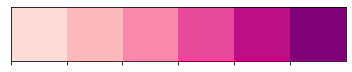

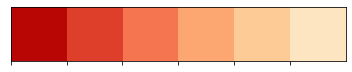

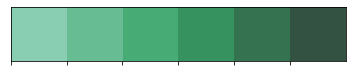

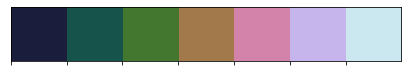

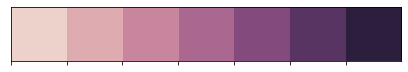

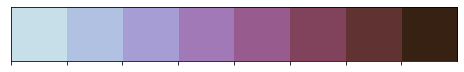

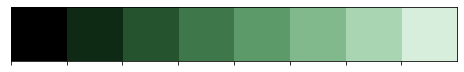

In [60]:
sns.palplot(sns.color_palette("RdPu"))
sns.palplot(sns.color_palette("OrRd_r"))
sns.palplot(sns.color_palette("BuGn_d"))

sns.palplot(sns.color_palette("cubehelix", 7))
sns.palplot(sns.cubehelix_palette(7))
sns.palplot(sns.cubehelix_palette(8, start=1.5, rot=-0.75))
sns.palplot(sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=0.9, reverse=True))


In [21]:
no_known =re.search("[^acgt]","atcg")
if no_known:
    print(no_known.group(0))
else:
    print(no_known)

None


In [22]:
# python 函数可以引用全局变量，但不能在函数内n+ =3 这样的形式
n = 1
def fun1():
    n +=3
    print(n+3)
#     global i
#     i+=1
    print(n)
print(n)
fun1()
print(i)

1


UnboundLocalError: local variable 'n' referenced before assignment

In [ ]:
n = 1
def fun1():
    n =3
    print(n+3)
#     global i
#     i+=1
    print(n)
print(n)
fun1()
print(n)